In [137]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import gensim
import string 
import math
import nltk

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from gensim import corpora, models  
from pprint import pprint
from collections import Counter
from datetime import datetime

In [138]:
df = pd.read_csv("./winemag-data-130k-v2.csv/winemag-data-130k-v2.csv")

In [139]:
df.head(1)

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimstone and dried herb. The palate isn't overly expressive, offering unripened apple, citrus and dried sage alongside brisk acidity.",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia


In [140]:
df.shape

(129971, 13)

In [141]:
df.nunique()

country                      43
description              119955
designation               37976
points                       21
price                       390
province                    425
region_1                   1229
region_2                     17
taster_name                  19
taster_twitter_handle        15
title                    118840
variety                     707
winery                    16757
dtype: int64

In [142]:
# Points range between 80 to 100
df['points'].unique()

array([ 87,  86,  85,  88,  92,  91,  90,  89,  83,  82,  81,  80, 100,
        98,  97,  96,  95,  93,  94,  84,  99], dtype=int64)

# Feature Engineering

1. Binning the column "Points" - Split into 4 bins
2. Convert "points" into target variables of 1,2,3,4

In [143]:
# Binning the column "Points" - Split into 4 bins

cut_labels_4 = ['average', 'good', 'very good', 'excellent']
cut_bins = [80, 85, 90, 95, 100]
df['ratings'] = pd.cut(df['points'], bins=cut_bins, labels=cut_labels_4)

In [144]:
# Function to convert to 0 and 1
def label(x):
    if x == 'average':
        return 1
    elif x == 'good':
        return 2
    elif x == 'very good':
        return 3
    else:
        return 4

# Apply the values throughout
df['ratings_label'] = df['ratings'].apply(lambda x: label(x))

In [145]:
df.sample(3)

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery,ratings,ratings_label
83379,US,"Pretty and polished, an elegant, lighter style Pinot Noir to drink now with rich pork, lamb and beef dishes or grilled salmon. It's silky and satiny, with pleasant wild strawberry, cherry, red currant, licorice, cola and cedar flavors.",NaN,87,35.0,California,Russian River Valley,Sonoma,NaN,NaN,J Vineyards & Winery 2008 Pinot Noir (Russian River Valley),Pinot Noir,J Vineyards & Winery,good,2
63568,Portugal,"The Santar estate is a showpiece in the Dão, producing ageworthy wines. This impressive, rich and juicy wine has structure, dark tannins and powerful black plum fruits. It's full of bold flavors and ready to age a few more years. Drink from 2017.",Conde de Santar,93,NaN,Dão,NaN,NaN,Roger Voss,@vossroger,Dão Sul 2009 Conde de Santar Red (Dão),Portuguese Red,Dão Sul,very good,3
4124,US,"A very agreeable, satisfying blend of ripe fruit and firm texture makes this full-bodied wine a winner. It has enough concentration to drench the palate with blackberries and linger on the finish with cinnamon accents.",Greenville Summit,90,48.0,California,Livermore Valley,Central Coast,Jim Gordon,@gordone_cellars,En Garde 2013 Greenville Summit Cabernet Sauvignon (Livermore Valley),Cabernet Sauvignon,En Garde,good,2


In [146]:
# Most wine falls under the good category, points range between (85-90)
df['ratings'].value_counts()

good         74376
very good    32754
average      21563
excellent      881
Name: ratings, dtype: int64

# Data Preprocessing

Stopword Removal Preparation

In [147]:
# Instantiate the set of stopwords
stopword_list = stopwords.words('english')

# storing the processed reviews into a list
description_values_list = df['description'].values.tolist()

complete_word_list = []

# for each word in the reviews which are alphanumberic and not present in the stopword list instantiated, store them in complete_word_list
  
for doc in description_values_list:
    for each_word in doc.split(" "):
        word_lowercase = each_word.lower()
        if word_lowercase.isalpha() and word_lowercase not in stopword_list:
            complete_word_list.append(each_word.lower())

# Pass the words_list  to instance of Counter class. 
word_counter = Counter(complete_word_list) 
# print(word_counter, "\n")

# most_common() produces k frequently encountered 
# The results will show the common words identified and their respective counts. 
top_100_occur_words = word_counter.most_common(100) 
print("Most common 100 words: ", top_100_occur_words, "\n")

def Convert(tup, dict): 
    for a, b in tup: 
        dict.setdefault(a, []).append(b) 
    return dict

word_counter_dict = {}
words = Convert(top_100_occur_words, word_counter_dict)
print(words.keys())

# Top 100 common words identified
# ['wine', 'flavors', 'aromas', 'fruit', 'drink', 'palate', 'black', 'ripe', 'acidity', 'tannins', 'red', 'cherry', 'notes', 'fresh', 'finish', 'offers', 'rich', 'spice', 'white', 'berry', 'shows', 'blend', 'nose', 'dark', 'plum', 'dry', 'crisp', 'oak', 'apple', 'sweet', 'cabernet', 'light', 'citrus', 'soft', 'full', 'bright', 'well', 'good', 'green', 'touch', 'blackberry', 'juicy', 'dried', 'fruits', 'vanilla', 'lemon', 'texture', 'firm', 'pepper', 'fruity', 'raspberry', 'pinot', 'also', 'made', 'hint', 'like', 'balanced', 'bit', 'give', 'peach', 'pear', 'still', 'opens', 'alongside', 'spicy', 'along', 'chocolate', 'slightly', 'hints', 'herbal', 'fine', 'lead', 'mineral', 'ready', 'great', 'wood', 'tart', 'concentrated', 'sauvignon', 'smooth', 'yet', 'orange', 'creamy', 'one', 'tannic', 'note', 'structure', 'savory', 'feels', 'new', 'delivers', 'character', 'herb', 'yellow', 'dense', 'almost', 'earthy', 'wild', 'little', 'currant']

# From the top 100 words we identified words which we will add into the stopword list
common_word_list = ['wine', 'drink', 'shows', 'also', 'made', 'like', 'bit', 'give', 'opens', 'alongside', 'along', 'ready',  'yet', 'one', 'feels', 'almost']

# Extend the existing stopword list with common words identified
stopword_list.extend(common_word_list)

Most common 100 words:  [('wine', 56151), ('flavors', 41815), ('aromas', 35267), ('fruit', 30011), ('drink', 26845), ('palate', 26193), ('black', 25235), ('ripe', 21520), ('acidity', 19611), ('tannins', 18284), ('red', 17731), ('cherry', 16892), ('notes', 15049), ('fresh', 13021), ('finish', 12716), ('offers', 12648), ('rich', 12496), ('spice', 11904), ('white', 11677), ('berry', 11449), ('shows', 11449), ('blend', 11346), ('nose', 9881), ('dark', 9874), ('plum', 9808), ('dry', 9662), ('crisp', 9624), ('oak', 9527), ('apple', 9442), ('sweet', 9439), ('cabernet', 9319), ('light', 9249), ('citrus', 8914), ('soft', 8913), ('full', 8817), ('bright', 8667), ('well', 8526), ('good', 8373), ('green', 8282), ('touch', 8278), ('blackberry', 8238), ('juicy', 7999), ('dried', 7839), ('fruits', 7812), ('vanilla', 7275), ('lemon', 7142), ('texture', 6842), ('firm', 6823), ('pepper', 6320), ('fruity', 6306), ('raspberry', 6239), ('pinot', 6203), ('also', 6150), ('made', 6113), ('hint', 5949), ('like

Data Prepreocessing (STEPS)

1. Convert text to lowercase
2. Tokenize sentences
3. Removal of stopwords based on stopword list generated above
4. Lemmatize the words 
5. Removal of punctuation

Return the processed text

In [148]:
# Instantiate lemmatizer
lemmatizer = WordNetLemmatizer()

def preprocess(x):
    
    # 1. Lower case
    tmp = x.lower()
    
    # 2. Tokenize the sentences
    tokens = word_tokenize(tmp)

    # 3. Remove stopwords
    no_stopwords = [word for word in tokens if word not in stopword_list and word.isalpha()]
    
    # 4. Lemmatize
    lemma_text = ' '.join([lemmatizer.lemmatize(word) for word in no_stopwords])

    # 5. Remove punctuations
    processed_text = lemma_text.translate(str.maketrans('', '', string.punctuation))
        
    return processed_text

In [149]:
# Apply text preprocessing on the main dataframe
df['cleaned_text'] = df['description'].apply(lambda x: preprocess(x))

In [152]:
df.head(2)

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery,ratings,ratings_label,cleaned_text
0,Italy,"Aromas include tropical fruit, broom, brimstone and dried herb. The palate isn't overly expressive, offering unripened apple, citrus and dried sage alongside brisk acidity.",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia,good,2,aroma include tropical fruit broom brimstone dried herb palate overly expressive offering unripened apple citrus dried sage brisk acidity
1,Portugal,"This is ripe and fruity, a wine that is smooth while still structured. Firm tannins are filled out with juicy red berry fruits and freshened with acidity. It's already drinkable, although it will certainly be better from 2016.",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos,good,2,ripe fruity smooth still structured firm tannin filled juicy red berry fruit freshened acidity already drinkable although certainly better


## Exporting the preprocessed DF to a CSV file

In [153]:
# df.to_csv(r"./winemag-data-130k-v2.csv/winemag-data-130k-v2-clean-desc.csv", index = False, encoding = 'utf-8-sig')

# N-Gram

In [201]:
reviews_cleaned = df['cleaned_text'].values.tolist()

# print(reviews_cleaned[0:2])
# ['aroma include tropical fruit broom brimstone dried herb palate overly expressive offering unripened apple citrus dried sage brisk acidity', 'ripe fruity smooth still structured firm tannin filled juicy red berry fruit freshened acidity already drinkable although certainly better']

bi = gensim.models.phrases.Phrases([review.split(" ") for review in reviews_cleaned], min_count=10, threshold=25)
df['bigram_cleaned_review'] = df['cleaned_text'].apply(lambda x: " ".join(bi[x.split(" ")]))

tri = gensim.models.phrases.Phrases(bi[reviews_cleaned], min_count=5, threshold=25)
df['trigram_cleaned_review'] = df['cleaned_text'].apply(lambda x: " ".join(tri[bi[x.split(" ")]]))

In [204]:
df.sample(1)

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery,ratings,ratings_label,cleaned_text,bigram_cleaned_review,trigram_cleaned_review
63546,Italy,"Leafy underbrush, truffle, woodland berry and toast aromas lead the nose. The chewy, solid palate offers ripe black cherry, crushed raspberry, grilled sage and ground aniseed alongside bracing tannins and assertive acidity. Drink 2018–2028.",Cannubi Boschis,90,70.0,Piedmont,Barolo,NaN,Kerin O’Keefe,@kerinokeefe,Cantina del Nebbiolo 2011 Cannubi Boschis (Barolo),Nebbiolo,Cantina del Nebbiolo,good,2,leafy underbrush truffle woodland berry toast aroma lead nose chewy solid palate offer ripe black cherry crushed raspberry grilled sage ground aniseed bracing tannin assertive acidity,leafy_underbrush truffle woodland_berry toast aroma lead nose chewy solid palate offer ripe black cherry crushed raspberry grilled_sage ground aniseed bracing tannin assertive acidity,leafy_underbrush truffle woodland_berry toast aroma lead nose chewy solid palate offer ripe black cherry crushed raspberry grilled_sage ground aniseed bracing tannin assertive acidity


# Part of Speech Tag

Allowed POS TAGS ==> Nouns and Verbs

Testing the effects of N-GRAM and POS

In [206]:
unigram_test = df['cleaned_text'][63546]
print("UNI-GRAM: ", unigram_test, "\n")

bigram_test = df['bigram_cleaned_review'][63546]
print("BI-GRAM: ", bigram_test, "\n")

trigram_test = df['trigram_cleaned_review'][63546]
print("TRI-GRAM: ", trigram_test, "\n")

unigram_test_sent = nltk.pos_tag([text for text in unigram_test.split(" ")])
print("unigram_test_sent: ", unigram_test_sent, "\n")

bigram_test_sent = nltk.pos_tag([text for text in bigram_test.split(" ")])
print("bigram_test_sent: ", bigram_test_sent, "\n")

trigram_test_sent = nltk.pos_tag([text for text in trigram_test.split(" ")])
print("trigram_test_sent: ", trigram_test_sent, "\n")

UNI-GRAM:  leafy underbrush truffle woodland berry toast aroma lead nose chewy solid palate offer ripe black cherry crushed raspberry grilled sage ground aniseed bracing tannin assertive acidity 

BI-GRAM:  leafy_underbrush truffle woodland_berry toast aroma lead nose chewy solid palate offer ripe black cherry crushed raspberry grilled_sage ground aniseed bracing tannin assertive acidity 

TRI-GRAM:  leafy_underbrush truffle woodland_berry toast aroma lead nose chewy solid palate offer ripe black cherry crushed raspberry grilled_sage ground aniseed bracing tannin assertive acidity 

unigram_test_sent:  [('leafy', 'JJ'), ('underbrush', 'JJ'), ('truffle', 'NN'), ('woodland', 'NN'), ('berry', 'NN'), ('toast', 'NN'), ('aroma', 'JJ'), ('lead', 'NN'), ('nose', 'JJ'), ('chewy', 'JJ'), ('solid', 'JJ'), ('palate', 'NN'), ('offer', 'NN'), ('ripe', 'JJ'), ('black', 'JJ'), ('cherry', 'NN'), ('crushed', 'VBD'), ('raspberry', 'NN'), ('grilled', 'VBN'), ('sage', 'NN'), ('ground', 'NN'), ('aniseed', '

Function to extract only terms whereby POS Tags are Nouns or Verbs

In [234]:
def pos_filter(sentence, allowed_postags=['NN', 'NNS', 'VB', 'VBD', 'VBG', 'VBP', 'VBZ']):
    word_list_with_valid_pos_tags = []
    word_pos = nltk.pos_tag([text for text in sentence.split(" ")])
    for word, pos in word_pos:
        if pos in allowed_postags:
            word_list_with_valid_pos_tags.append(word)
    return word_list_with_valid_pos_tags

# print(pos_filter(df['cleaned_text'][63546], allowed_postags=['NN', 'NNS', 'VB', 'VBD', 'VBG', 'VBP', 'VBZ']))

In [236]:
# Apply to df for uni, bi and tri gram

# Uni-gram
df['unigram_cleaned_review_noun_verbs_only'] = df['cleaned_text'].apply(lambda x: " ".join(pos_filter(x)))

# Uni-gram
df['bigram_cleaned_review_noun_verbs_only'] = df['bigram_cleaned_review'].apply(lambda x: " ".join(pos_filter(x)))

# Uni-gram
df['trigram_cleaned_review_noun_verbs_only'] = df['trigram_cleaned_review'].apply(lambda x: " ".join(pos_filter(x)))

In [247]:
df.iloc[63546:63547]

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,...,variety,winery,ratings,ratings_label,cleaned_text,bigram_cleaned_review,trigram_cleaned_review,unigram_cleaned_review_noun_verbs_only,bigram_cleaned_review_noun_verbs_only,trigram_cleaned_review_noun_verbs_only
63546,Italy,"Leafy underbrush, truffle, woodland berry and toast aromas lead the nose. The chewy, solid palate offers ripe black cherry, crushed raspberry, grilled sage and ground aniseed alongside bracing tannins and assertive acidity. Drink 2018–2028.",Cannubi Boschis,90,70.0,Piedmont,Barolo,NaN,Kerin O’Keefe,@kerinokeefe,...,Nebbiolo,Cantina del Nebbiolo,good,2,leafy underbrush truffle woodland berry toast aroma lead nose chewy solid palate offer ripe black cherry crushed raspberry grilled sage ground aniseed bracing tannin assertive acidity,leafy_underbrush truffle woodland_berry toast aroma lead nose chewy solid palate offer ripe black cherry crushed raspberry grilled_sage ground aniseed bracing tannin assertive acidity,leafy_underbrush truffle woodland_berry toast aroma lead nose chewy solid palate offer ripe black cherry crushed raspberry grilled_sage ground aniseed bracing tannin assertive acidity,truffle woodland berry toast lead palate offer cherry crushed raspberry sage ground aniseed bracing tannin acidity,leafy_underbrush truffle woodland_berry lead palate offer cherry crushed grilled_sage ground aniseed bracing tannin acidity,leafy_underbrush truffle woodland_berry lead palate offer cherry crushed grilled_sage ground aniseed bracing tannin acidity


# Export to CSV

In [238]:
# df.to_csv(r"./winemag-data-130k-v2.csv/winemag-data-130k-v2-clean-desc-ngram-pos.csv", index = False, encoding = 'utf-8-sig')

# Create a small subset to visualize data pre-processing

In [288]:
df_sample_500_records = df.iloc[0:500, :]

In [289]:
# storing the processed reviews of the 500 sample records into a list

# UNIGRAM
sample_500_records_cleaned_text = df_sample_500_records['unigram_cleaned_review_noun_verbs_only'].values.tolist()

## Create dictionary using the series with the cleaned reviews (Stopwords Removal, POS tag filter etc.)
## UNIGRAM

In [290]:
cleaned_unigram_text_list_split = [d.split() for d in sample_500_records_cleaned_text]
# print(cleaned_unigram_text_list_split[0:2])

dictionary = gensim.corpora.Dictionary(cleaned_unigram_text_list_split)
# print(dictionary)

bow_corpus = [dictionary.doc2bow(doc) for doc in cleaned_unigram_text_list_split]
# bow_corpus[0:2]

## Choosing Optimal Number of Topics for LDA using BOW (Using 500 Records)
## UNIGRAM

In [291]:
from gensim.models import CoherenceModel

model_topics = []
model_list = []
coherence_values = []

for num_topics in range(2, 12, 2):
    lda_bow_model = gensim.models.LdaMulticore(corpus=bow_corpus, num_topics=num_topics, id2word=dictionary, passes=2, workers=2,  random_state=100)
    coherencemodel = CoherenceModel(model=lda_bow_model, texts=cleaned_unigram_text_list_split, dictionary=dictionary, coherence='c_v')
    model_topics.append(num_topics)
    model_list.append(lda_bow_model)
    coherence_values.append(coherencemodel.get_coherence())
    print("#Topics: " + str(num_topics) + " Score: " + str(coherencemodel.get_coherence()))

#Topics: 2 Score: 0.27393038648537765
#Topics: 4 Score: 0.25173168449668043
#Topics: 6 Score: 0.24883750575750704
#Topics: 8 Score: 0.2462113773961394
#Topics: 10 Score: 0.27048788418101594


## Plotting of Coherence Graph (Using 500 Records)
## UNIGRAM

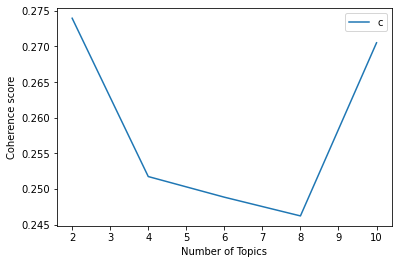

In [292]:
# Show graph
limit=12; start=2; step=2;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

## Generating LDA Model with BoW implementation (Using Optimal number of topics (500 Records)) and saving the Model
## UNIGRAM

In [293]:
# Train our lda model using gensim.models.LdaMulticore and save it to ‘lda_model’
lda_bow_unigram_500_model = gensim.models.LdaMulticore(corpus=bow_corpus, num_topics=2, id2word=dictionary, passes=2, workers=2, random_state=100)

# save model to disk
import pickle

with open("lda_bow_unigram_500_model.pk", "wb") as file:
   pickle.dump(lda_bow_unigram_500_model, file)

# For each topic, we will explore the words occuring in that topic and its relative weight.

# Parameters
# num_topics (int, optional) – The number of topics to be selected, if -1 - all topics will be in result (ordered by significance).

for idx, topic in lda_bow_unigram_500_model.print_topics(-1):
    print('Topic: {} \nWords: {}\n'.format(idx + 1, topic))

Topic: 1 
Words: 0.027*"flavor" + 0.024*"aroma" + 0.022*"fruit" + 0.016*"palate" + 0.013*"tannin" + 0.013*"cherry" + 0.011*"spice" + 0.010*"note" + 0.009*"finish" + 0.008*"acidity"

Topic: 2 
Words: 0.030*"flavor" + 0.024*"fruit" + 0.019*"acidity" + 0.017*"palate" + 0.013*"note" + 0.011*"cherry" + 0.010*"offer" + 0.010*"finish" + 0.009*"apple" + 0.009*"ripe"



## Assign topic back to documents (BOW LDA MODEL) - 500 RECORDS UNIGRAM

In [294]:
df_sample_500_records['topics'] = [lda_bow_unigram_500_model.get_document_topics(dictionary.doc2bow(doc)) for doc in cleaned_unigram_text_list_split]

In [295]:
df_sample_500_records.head(1)

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,...,winery,ratings,ratings_label,cleaned_text,bigram_cleaned_review,trigram_cleaned_review,unigram_cleaned_review_noun_verbs_only,bigram_cleaned_review_noun_verbs_only,trigram_cleaned_review_noun_verbs_only,topics
0,Italy,"Aromas include tropical fruit, broom, brimstone and dried herb. The palate isn't overly expressive, offering unripened apple, citrus and dried sage alongside brisk acidity.",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,...,Nicosia,good,2,aroma include tropical fruit broom brimstone dried herb palate overly expressive offering unripened apple citrus dried sage brisk acidity,aroma include tropical fruit broom brimstone dried herb palate overly expressive offering unripened apple citrus dried sage brisk acidity,aroma include tropical fruit broom brimstone dried herb palate overly expressive offering unripened apple citrus dried sage brisk acidity,aroma include fruit broom brimstone dried palate offering apple citrus dried sage brisk acidity,aroma include fruit broom brimstone dried palate offering apple citrus dried sage brisk acidity,aroma include fruit broom brimstone dried palate offering apple citrus dried sage brisk acidity,"[(0, 0.9415033), (1, 0.058496695)]"


# TF-IDF Implementation

## Create TF-IDF model object on bow_corpus and name it corpus_tfidf

In [296]:
tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]

for doc in corpus_tfidf:
    pprint(doc)
    break

[(0, 0.09462006626302034),
 (1, 0.14525132853822625),
 (2, 0.08838625392344406),
 (3, 0.4290846571513522),
 (4, 0.3532314947701073),
 (5, 0.4290846571513522),
 (6, 0.1549577423826127),
 (7, 0.43133020543717104),
 (8, 0.06608339247721966),
 (9, 0.30537347772129264),
 (10, 0.2701037657512966),
 (11, 0.08358956702080839),
 (12, 0.2855106060049084)]


## Choosing Optimal Number of Topics for LDA using TF-IDF
## UNIGRAM - 500 Records

In [297]:
from gensim.models import CoherenceModel

model_topics = []
model_list = []
coherence_values = []

for num_topics in range(2, 12, 2):
    lda_tfidf_model= gensim.models.LdaMulticore(corpus=corpus_tfidf, num_topics=num_topics, id2word=dictionary, passes=2, workers=2,  random_state=100)
    coherencemodel = CoherenceModel(model=lda_tfidf_model, texts=cleaned_unigram_text_list_split, dictionary=dictionary, coherence='c_v')
    model_topics.append(num_topics)
    model_list.append(lda_tfidf_model)
    coherence_values.append(coherencemodel.get_coherence())
    print("#Topics: " + str(num_topics) + " Score: " + str(coherencemodel.get_coherence()))

#Topics: 2 Score: 0.23616653755798916
#Topics: 4 Score: 0.23894855155221956
#Topics: 6 Score: 0.245879230407441
#Topics: 8 Score: 0.2611776422600284
#Topics: 10 Score: 0.30105764703737947


## Plotting of Coherence Graph (TF-IDF BoW Implementation)

## UNIGRAM - 500 Records

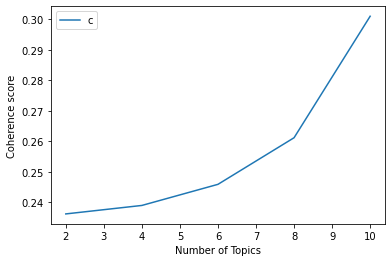

In [298]:
# Show graph
limit=12; start=2; step=2;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

## LDA using TF-IDF

## UNIGRAM - 500 Records (Optimal Number of topics --> 10)

In [299]:
lda_tfidf_unigram_500_model = gensim.models.LdaMulticore(corpus=corpus_tfidf, num_topics=10, id2word=dictionary, passes=2, workers=2, random_state=100)

# save model to disk
with open("lda_tfidf_unigram_500_model.pk", "wb") as file:
   pickle.dump(lda_tfidf_unigram_500_model, file)

for idx, topic in lda_tfidf_unigram_500_model.print_topics(-1):
    print('Topic: {}\nWord: {}\n'.format(idx+1, topic))

Topic: 1
Word: 0.006*"cherry" + 0.005*"cabernet" + 0.005*"spice" + 0.005*"blend" + 0.005*"berry" + 0.004*"franc" + 0.004*"note" + 0.004*"flavor" + 0.004*"aroma" + 0.004*"merlot"

Topic: 2
Word: 0.006*"cherry" + 0.005*"cabernet" + 0.005*"raspberry" + 0.005*"fruit" + 0.005*"flavor" + 0.004*"berry" + 0.004*"hint" + 0.004*"spice" + 0.004*"palate" + 0.004*"offer"

Topic: 3
Word: 0.006*"ripe" + 0.006*"spice" + 0.005*"apple" + 0.005*"fruit" + 0.005*"acidity" + 0.005*"offer" + 0.005*"note" + 0.005*"balance" + 0.004*"palate" + 0.004*"finish"

Topic: 4
Word: 0.006*"flavor" + 0.005*"oak" + 0.004*"melon" + 0.004*"palate" + 0.004*"acidity" + 0.004*"finish" + 0.004*"fruit" + 0.004*"spicy" + 0.004*"pear" + 0.004*"cherry"

Topic: 5
Word: 0.005*"dried" + 0.005*"offer" + 0.004*"plum" + 0.004*"tannin" + 0.004*"aroma" + 0.004*"acidity" + 0.004*"make" + 0.004*"texture" + 0.004*"berry" + 0.004*"ripe"

Topic: 6
Word: 0.005*"structure" + 0.005*"fruit" + 0.004*"accent" + 0.004*"cinnamon" + 0.004*"palate" + 0.0

# Visualize Topics with pyLDAvis

## Unigram TF-IDF LDA Implementation

In [ ]:
import pyLDAvis.gensim
import pyLDAvis

# Reload LDA BOW Model (UNIGRAM - 500 Records)
with open('lda_bow_unigram_500_model.pk', 'rb') as file_1:
    lda_bow_unigram_500_model_obj = pickle.load(file_1)

# Visualize the topics
pyLDAvis.enable_notebook()
LDAvis_prepared = pyLDAvis.gensim.prepare(lda_bow_unigram_500_model_obj, corpus_tfidf, dictionary)
LDAvis_prepared

# Testing the saved Model (BoW Implementation) - UNIGRAM 500 Records

In [344]:
# Reload LDA BOW Model (UNIGRAM - 500 Records)
with open('lda_bow_unigram_500_model.pk', 'rb') as file_1:
    lda_bow_unigram_500_model_obj = pickle.load(file_1)

unseen_document = "Delivering profound notes of black and red currants, blackberry fruit, blood orange citrus, and dried raspberries underscored by baking spices and dried red florals, this pinot noir is also a textural masterpiece with mouthwatering acidity and grippy cedar-like tannins"

unseen_document_list = [x for x in unseen_document.lower().split()]
bow_vector_test_doc = dictionary.doc2bow((unseen_document_list))

for index, score in sorted(lda_bow_unigram_500_model_obj[bow_vector_test_doc], key = lambda x: -1 * x[1]):
    print("Score: {}\nTopic Number: {}\nTopic Keywords: {}".format(score, lda_bow_unigram_500_model_obj.show_topics()[index][0],lda_bow_unigram_500_model_obj.print_topic(index, 10)), "\n")

Score: 0.9323858618736267
Topic Number: 0
Topic Keywords: 0.027*"flavor" + 0.024*"aroma" + 0.022*"fruit" + 0.016*"palate" + 0.013*"tannin" + 0.013*"cherry" + 0.011*"spice" + 0.010*"note" + 0.009*"finish" + 0.008*"acidity" 

Score: 0.0676141083240509
Topic Number: 1
Topic Keywords: 0.030*"flavor" + 0.024*"fruit" + 0.019*"acidity" + 0.017*"palate" + 0.013*"note" + 0.011*"cherry" + 0.010*"offer" + 0.010*"finish" + 0.009*"apple" + 0.009*"ripe" 



In [314]:
# Print Number of topics 
print("Number of topic present in the saved model: ", lda_bow_unigram_500_model_obj.num_topics, "\n")

# print all topics
print("TOPICS: ")
lda_bow_unigram_500_model_obj.show_topics()

Number of topic present in the saved model:  2 

TOPICS: 


[(0,
  '0.027*"flavor" + 0.024*"aroma" + 0.022*"fruit" + 0.016*"palate" + 0.013*"tannin" + 0.013*"cherry" + 0.011*"spice" + 0.010*"note" + 0.009*"finish" + 0.008*"acidity"'),
 (1,
  '0.030*"flavor" + 0.024*"fruit" + 0.019*"acidity" + 0.017*"palate" + 0.013*"note" + 0.011*"cherry" + 0.010*"offer" + 0.010*"finish" + 0.009*"apple" + 0.009*"ripe"')]

## Testing the saved Model (TF-IDF Implementation) - UNIGRAM 500 Records

In [345]:
# Reload LDA TFIDF Model (UNIGRAM - 500 Records)
with open('lda_tfidf_unigram_500_model.pk', 'rb') as file_2:
    lda_tfidf_unigram_500_model_obj = pickle.load(file_2)

for index, score in sorted(lda_tfidf_unigram_500_model_obj[bow_vector_test_doc], key = lambda x: -1 * x[1]):
    print("Score: {}\nTopic Number: {}\nTopic Keywords: {}".format(score, lda_tfidf_unigram_500_model_obj.show_topics()[index][0],lda_tfidf_unigram_500_model_obj.print_topic(index, 10)), "\n")

Score: 0.3211032748222351
Topic Number: 4
Topic Keywords: 0.005*"dried" + 0.005*"offer" + 0.004*"plum" + 0.004*"tannin" + 0.004*"aroma" + 0.004*"acidity" + 0.004*"make" + 0.004*"texture" + 0.004*"berry" + 0.004*"ripe" 

Score: 0.2571210265159607
Topic Number: 9
Topic Keywords: 0.008*"citrus" + 0.007*"fruit" + 0.005*"spice" + 0.005*"apple" + 0.005*"stone" + 0.005*"aroma" + 0.005*"acidity" + 0.005*"palate" + 0.004*"hint" + 0.004*"offer" 

Score: 0.22114259004592896
Topic Number: 1
Topic Keywords: 0.006*"cherry" + 0.005*"cabernet" + 0.005*"raspberry" + 0.005*"fruit" + 0.005*"flavor" + 0.004*"berry" + 0.004*"hint" + 0.004*"spice" + 0.004*"palate" + 0.004*"offer" 

Score: 0.1505971997976303
Topic Number: 2
Topic Keywords: 0.006*"ripe" + 0.006*"spice" + 0.005*"apple" + 0.005*"fruit" + 0.005*"acidity" + 0.005*"offer" + 0.005*"note" + 0.005*"balance" + 0.004*"palate" + 0.004*"finish" 



# Implementation on Full dataset (Bags of Words Implementation)

## UNIGRAM

In [ ]:
# UNIGRAM
full_records_cleaned_text = df['unigram_cleaned_review_noun_verbs_only'].values.tolist()

full_cleaned_unigram_text_list_split = [d.split() for d in full_records_cleaned_text]
# print(cleaned_unigram_text_list_split[0:2])

dictionary_full_unigram = gensim.corpora.Dictionary(full_cleaned_unigram_text_list_split)
# print(dictionary)

full_unigram_bow_corpus = [dictionary_full_unigram.doc2bow(doc) for doc in full_cleaned_unigram_text_list_split]
# bow_corpus[0:2]

In [ ]:
from gensim.models import CoherenceModel

model_topics = []
model_list = []
coherence_values = []

for num_topics in range(2, 12, 2):
    full_unigram_lda_bow_model = gensim.models.LdaMulticore(corpus=full_unigram_bow_corpus, num_topics=num_topics, id2word=dictionary_full_unigram, passes=2, workers=2,  random_state=100)
    coherencemodel = CoherenceModel(model=full_unigram_lda_bow_model, texts=full_cleaned_unigram_text_list_split, dictionary=dictionary_full_unigram, coherence='c_v')
    model_topics.append(num_topics)
    model_list.append(full_unigram_lda_bow_model)
    coherence_values.append(coherencemodel.get_coherence())
    print("#Topics: " + str(num_topics) + " Score: " + str(coherencemodel.get_coherence()))

# Show graph
limit=12; start=2; step=2;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [ ]:
# Train our lda model using gensim.models.LdaMulticore and save it to ‘lda_model’

# Change the num_topics based on results obtained above
lda_bow_unigram_full_model = gensim.models.LdaMulticore(corpus=bow_corpus, num_topics=2, id2word=dictionary, passes=2, workers=2, random_state=100)

# save model to disk
import pickle

with open("lda_bow_unigram_full_model.pk", "wb") as file:
   pickle.dump(lda_bow_unigram_full_model, file)

# For each topic, we will explore the words occuring in that topic and its relative weight.
for idx, topic in lda_bow_unigram_full_model.print_topics(-1):
    print('Topic: {} \nWords: {}\n'.format(idx + 1, topic))

## BIGRAM 

In [ ]:
full_records_cleaned_text_bigram = df['bigram_cleaned_review_noun_verbs_only'].values.tolist()

full_cleaned_bigram_text_list_split = [d.split() for d in full_records_cleaned_text_bigram]

dictionary_full_bigram = gensim.corpora.Dictionary(full_cleaned_bigram_text_list_split)

full_bigram_bow_corpus = [dictionary_full_bigram.doc2bow(doc) for doc in full_cleaned_bigram_text_list_split]

In [ ]:
model_topics = []
model_list = []
coherence_values = []

for num_topics in range(2, 12, 2):
    full_bigram_lda_bow_model = gensim.models.LdaMulticore(corpus=full_bigram_bow_corpus, num_topics=num_topics, id2word=dictionary_full_bigram, passes=2, workers=2,  random_state=100)
    coherencemodel = CoherenceModel(model=full_bigram_lda_bow_model, texts=full_cleaned_bigram_text_list_split, dictionary=dictionary_full_bigram, coherence='c_v')
    model_topics.append(num_topics)
    model_list.append(full_bigram_lda_bow_model)
    coherence_values.append(coherencemodel.get_coherence())
    print("#Topics: " + str(num_topics) + " Score: " + str(coherencemodel.get_coherence()))

# Show graph
limit=12; start=2; step=2;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [ ]:
# Change the num_topics based on results obtained above
lda_bow_bigram_full_model = gensim.models.LdaMulticore(corpus=full_bigram_bow_corpus, num_topics=2, id2word=dictionary_full_bigram, passes=2, workers=2, random_state=100)

# save model to disk
with open("lda_bow_bigram_full_model.pk", "wb") as file:
   pickle.dump(lda_bow_bigram_full_model, file)

# For each topic, we will explore the words occuring in that topic and its relative weight.
for idx, topic in lda_bow_bigram_full_model.print_topics(-1):
    print('Topic: {} \nWords: {}\n'.format(idx + 1, topic))

## TRIGRAM 

In [ ]:
full_records_cleaned_text_trigram = df['trigram_cleaned_review_noun_verbs_only'].values.tolist()

full_cleaned_trigram_text_list_split = [d.split() for d in full_records_cleaned_text_trigram]

dictionary_full_trigram = gensim.corpora.Dictionary(full_cleaned_trigram_text_list_split)

full_trigram_bow_corpus = [dictionary_full_trigram.doc2bow(doc) for doc in full_cleaned_trigram_text_list_split]

In [ ]:
model_topics = []
model_list = []
coherence_values = []

for num_topics in range(2, 12, 2):
    full_trigram_lda_bow_model = gensim.models.LdaMulticore(corpus=full_trigram_bow_corpus, num_topics=num_topics, id2word=dictionary_full_trigram, passes=2, workers=2,  random_state=100)
    coherencemodel = CoherenceModel(model=full_trigram_lda_bow_model, texts=full_cleaned_trigram_text_list_split, dictionary=dictionary_full_trigram, coherence='c_v')
    model_topics.append(num_topics)
    model_list.append(full_trigram_lda_bow_model)
    coherence_values.append(coherencemodel.get_coherence())
    print("#Topics: " + str(num_topics) + " Score: " + str(coherencemodel.get_coherence()))

# Show graph
limit=12; start=2; step=2;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [ ]:
# Change the num_topics based on results obtained above
lda_bow_trigram_full_model = gensim.models.LdaMulticore(corpus=full_trigram_bow_corpus, num_topics=2, id2word=dictionary_full_trigram, passes=2, workers=2, random_state=100)

# save model to disk
with open("lda_bow_trigram_full_model.pk", "wb") as file:
   pickle.dump(lda_bow_trigram_full_model, file)

# For each topic, we will explore the words occuring in that topic and its relative weight.
for idx, topic in lda_bow_trigram_full_model.print_topics(-1):
    print('Topic: {} \nWords: {}\n'.format(idx + 1, topic))

# Implementation on Full dataset (TF-IDF Implementation)

 

## Create TF-IDF model object on bow_corpus and name it corpus_tfidf (Unigram)

In [ ]:
tfidf_unigram_model = models.TfidfModel(full_unigram_bow_corpus)
corpus_tfidf_unigram = tfidf_unigram_model[full_unigram_bow_corpus]

In [ ]:
model_topics = []
model_list = []
coherence_values = []

for num_topics in range(2, 12, 2):
    unigram_lda_tfidf_model= gensim.models.LdaMulticore(corpus=corpus_tfidf_unigram, num_topics=num_topics, id2word=dictionary_full_bigram, passes=2, workers=2,  random_state=100)
    coherencemodel = CoherenceModel(model=unigram_lda_tfidf_model, texts=full_cleaned_unigram_text_list_split, dictionary=dictionary_full_bigram, coherence='c_v')
    model_topics.append(num_topics)
    model_list.append(unigram_lda_tfidf_model)
    coherence_values.append(coherencemodel.get_coherence())
    print("#Topics: " + str(num_topics) + " Score: " + str(coherencemodel.get_coherence()))

In [ ]:
# Show graph
limit=12; start=2; step=2;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [ ]:
lda_tfidf_unigram_full_model = gensim.models.LdaMulticore(corpus=corpus_tfidf_unigram, num_topics=10, id2word=dictionary_full_unigram, passes=2, workers=2, random_state=100)

# save model to disk
with open("lda_tfidf_unigram_full_model.pk", "wb") as file:
   pickle.dump(lda_tfidf_unigram_full_model, file)

for idx, topic in lda_tfidf_unigram_full_model.print_topics(-1):
    print('Topic: {}\nWord: {}\n'.format(idx+1, topic))

## BIGRAM

In [ ]:
tfidf_bigram_model = models.TfidfModel(full_bigram_bow_corpus)
corpus_tfidf_bigram = tfidf_bigram_model[full_bigram_bow_corpus]

In [ ]:
model_topics = []
model_list = []
coherence_values = []

for num_topics in range(2, 12, 2):
    bigram_lda_tfidf_model= gensim.models.LdaMulticore(corpus=corpus_tfidf_bigram, num_topics=num_topics, id2word=dictionary_full_bigram, passes=2, workers=2,  random_state=100)
    coherencemodel = CoherenceModel(model=bigram_lda_tfidf_model, texts=full_cleaned_bigram_text_list_split, dictionary=dictionary_full_bigram, coherence='c_v')
    model_topics.append(num_topics)
    model_list.append(bigram_lda_tfidf_model)
    coherence_values.append(coherencemodel.get_coherence())
    print("#Topics: " + str(num_topics) + " Score: " + str(coherencemodel.get_coherence()))

In [ ]:
# Show graph
limit=12; start=2; step=2;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [ ]:
lda_tfidf_bigram_full_model = gensim.models.LdaMulticore(corpus=corpus_tfidf_bigram, num_topics=10, id2word=dictionary_full_bigram, passes=2, workers=2, random_state=100)

# save model to disk
with open("lda_tfidf_bigram_full_model.pk", "wb") as file:
   pickle.dump(lda_tfidf_bigram_full_model, file)

for idx, topic in lda_tfidf_bigram_full_model.print_topics(-1):
    print('Topic: {}\nWord: {}\n'.format(idx+1, topic))

## TRIGRAM

In [ ]:
tfidf_trigram_model = models.TfidfModel(full_trigram_bow_corpus)
corpus_tfidf_trigram = tfidf_trigram_model[full_trigram_bow_corpus]

In [ ]:
model_topics = []
model_list = []
coherence_values = []

for num_topics in range(2, 12, 2):
    trigram_lda_tfidf_model= gensim.models.LdaMulticore(corpus=corpus_tfidf_trigram, num_topics=num_topics, id2word=dictionary_full_trigram, passes=2, workers=2,  random_state=100)
    coherencemodel = CoherenceModel(model=trigram_lda_tfidf_model, texts=full_cleaned_trigram_text_list_split, dictionary=dictionary_full_trigram, coherence='c_v')
    model_topics.append(num_topics)
    model_list.append(trigram_lda_tfidf_model)
    coherence_values.append(coherencemodel.get_coherence())
    print("#Topics: " + str(num_topics) + " Score: " + str(coherencemodel.get_coherence()))

In [ ]:
# Show graph
limit=12; start=2; step=2;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [ ]:
lda_tfidf_trigram_full_model = gensim.models.LdaMulticore(corpus=corpus_tfidf_trigram, num_topics=10, id2word=dictionary_full_trigram, passes=2, workers=2, random_state=100)

# save model to disk
with open("lda_tfidf_trigram_full_model.pk", "wb") as file:
   pickle.dump(lda_tfidf_trigram_full_model, file)

for idx, topic in lda_tfidf_trigram_full_model.print_topics(-1):
    print('Topic: {}\nWord: {}\n'.format(idx+1, topic))